# Quantum Eigenvalue Transformation

In [47]:
import numpy as np
from scipy.linalg import expm, sinm, cosm, sqrtm
import matplotlib.pyplot as plt

In [48]:
X_gate = np.array([[0, 1], [1, 0]], dtype = 'complex_')
Y_gate = np.array([[0, -1j], [1j, 0]], dtype = 'complex_')
Z_gate = np.array([[1, 0], [0, -1]], dtype = 'complex_')

H_gate = np.array([[1, 1], [1, -1]], dtype = 'complex_') / np.sqrt(2)

### Hamiltonian
Example: $H = \frac{1}{10} \cdot Z_1 \otimes Y_2 \otimes Z_3 + \frac25 \cdot X_1 \otimes Y_2 \otimes Y_3 - \frac15 \cdot Y_1 \otimes Y_2 \otimes Y_3 + \frac{1}{20} \cdot I_1 \otimes Z_2 \otimes X_3 + \frac{9}{20} \cdot I_1 \otimes I_2 \otimes I_3$

In [49]:
H = 0.1 * np.kron(Z_gate, np.kron(Y_gate, Y_gate)) + 0.4 * np.kron(X_gate, np.kron(Y_gate, Y_gate)) - 0.2 * np.kron(Y_gate, np.kron(Y_gate, Y_gate)) + 0.05 * np.kron(np.eye(2), np.kron(Z_gate, X_gate)) + 0.45 * np.kron(np.eye(2), np.kron(np.eye(2), np.eye(2)))

# norm of Hamiltonian mus be smaller than 1
H = H / (1.25 * np.linalg.norm(H))
np.linalg.norm(H)

0.8

### Block encoding
$$
U =
\begin{bmatrix}
\mathcal{H} & \cdot \\
\cdot & \cdot
\end{bmatrix}
=
\begin{bmatrix}
\mathcal{H} & \sqrt{I - \mathcal{H}^2} \\
\sqrt{I - \mathcal{H}^2} & -\mathcal{H}
\end{bmatrix}
=
Z \otimes \mathcal{H} + \mathcal{H} \otimes \sqrt{\mathcal{I} - \mathcal{H}^2}
$$

In [50]:
U = np.kron(Z_gate, H) + np.kron(X_gate, sqrtm(np.eye(H.shape[0]) - H @ H))

Check if U is unitary
$$
UU^{\dagger} = U^{\dagger}U =  I
$$
and if the the spectral norm is 1.

In [51]:
#check whether unitary
print(np.allclose(U @ U.conj().T, np.identity(U.shape[0])))
print(np.linalg.norm(U,2))

True
1.0000000000000007


### Projector-controlled phase shift
The projector-controlled phase-shift operation is defines as $\Pi_{\phi} = e^{i\phi Z} \otimes I$ with $\Pi = \ket{0} \bra{0}$ 

In [52]:
projector = np.outer(np.array([1, 0]), np.array([1, 0]))

def phase_shift(phi):
    """
    performs the projector-controlled phase shift operation for a given phase phi and a globaly defined projector Pi
    """
    dim = H.shape[0]
    return np.kron(expm(1j*phi*Z_gate), np.eye(dim))


### Eigenvalue Transformation
$$
U_{\vec{\phi}, \textrm{eig}} = \Pi_{\phi_0} \prod_{k=1}^{d} U \Pi_{\phi_{k}}
$$

In [53]:
def QEVT(phi_vec, U):
    """
    Performs the eigenvalue transformation
    """
    assert U.shape[0] == U.shape[1], "QEVT only supports square matrices"

    dim = U.shape[0]
    d = len(phi_vec)

    result = phase_shift(phi_vec[0])

    for k in range(1, d):
        result = result @ (U @ phase_shift(phi_vec[k]))
    
    return result

## Example 1: The Eigenvalue Threshold Problem

λ: [-0.0255784  -0.0255784   0.01832731  0.01832731  0.37682403  0.37682403
  0.42072973  0.42072973]


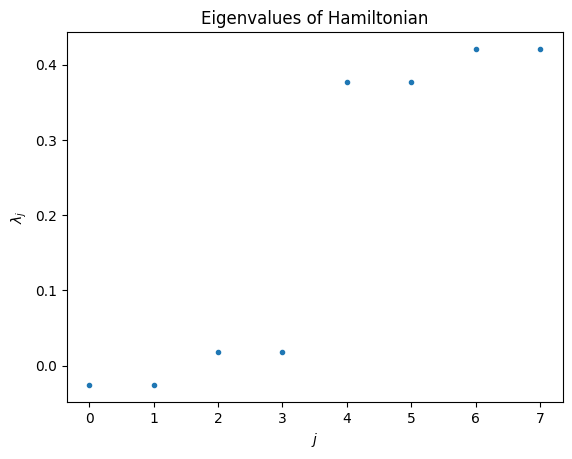

In [54]:
λ, ψ = np.linalg.eigh(H)
print("λ:", λ)
plt.plot(λ, ".")
plt.xlabel(r"$j$")
plt.ylabel(r"$\lambda_j$")
plt.title("Eigenvalues of Hamiltonian")
plt.show()

### Calculate the phase angles

[pyqsp.poly.PolyEfilter] degree=30, delta=0.3
[PolyTaylorSeries] max [0.94955034] is at [2.19000128e-08]: normalizing
[PolyTaylorSeries] average error = 0.009629178075583878 in the domain [-1, 1] using degree 30


c:\Python311\Lib\site-packages\scipy\interpolate\_polyint.py:502: UserWarning: 31 degrees provided, degrees higher than about thirty cause problems with numerical instability with 'KroghInterpolator'
  P = KroghInterpolator(xs, f(xs))


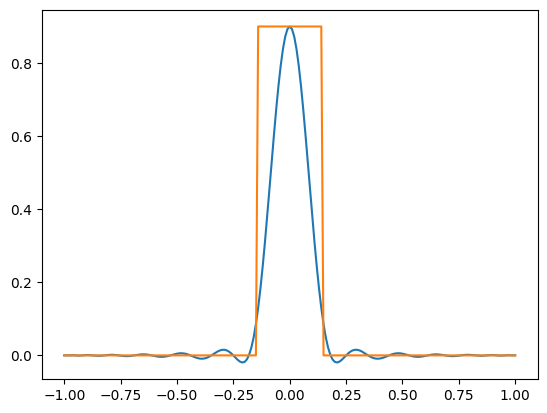

In [55]:
import pyqsp
from pyqsp.angle_sequence import QuantumSignalProcessingPhases

pg = pyqsp.poly.PolyEigenstateFiltering()
pcoeffs, scale = pg.generate(30, 0.3, ensure_bounded=True, return_scale=True)
ang_seq = QuantumSignalProcessingPhases(pcoeffs, signal_operator="Wx")

poly_filt = np.polynomial.Polynomial(pcoeffs)
poly_filt.degree()

a_list = np.linspace(-1, 1, 201)
plt.plot(a_list, poly_filt(a_list), label="polynomial")


def target_filt(x, delta, scale=1):
    """
    Target function for eigenvalue filtering.
    """
    return scale * (np.sign(x + 0.5*delta) - np.sign(x - 0.5*delta)) / 2

plt.plot(a_list, target_filt(a_list, 0.3, scale=0.9), label="target function")

### Apply eigenvalue filtering to Hamiltonian

Expected result

In [56]:
Poly_λ = poly_filt(λ)
#Poly_λ = target_filt(λ, 0.3)

Poly_λ: [ 0.85490753  0.85490753  0.87662316  0.87662316 -0.00822764 -0.00822764
 -0.00493857 -0.00493857]


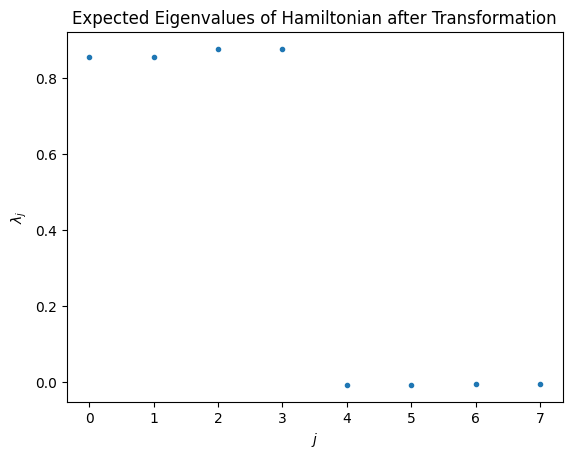

In [57]:
print("Poly_λ:", Poly_λ)
plt.plot(Poly_λ, ".")
plt.xlabel(r"$j$")
plt.ylabel(r"$\lambda_j$")
plt.title("Expected Eigenvalues of Hamiltonian after Transformation")
plt.show()

λ: [-1.08620577 -1.07323062 -0.93428266 -0.9309452  -0.03449161  0.1044243
  0.15836727  0.31364798]


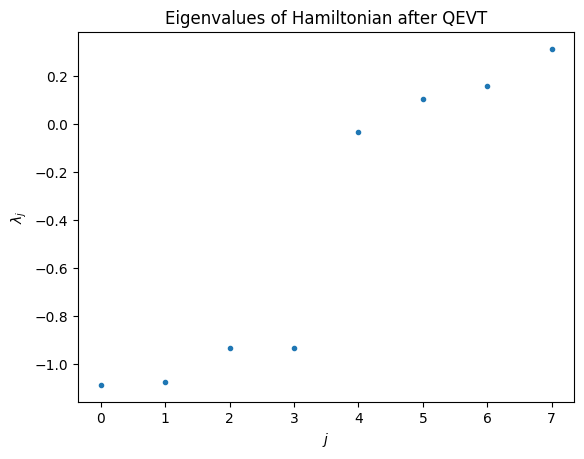

In [43]:
Poly_H = QEVT(ang_seq, U)[0:8, 0:8]
λ, ψ = np.linalg.eigh(Poly_H)
print("λ:", λ)
plt.plot(λ, ".")
plt.xlabel(r"$j$")
plt.ylabel(r"$\lambda_j$")
plt.title("Eigenvalues of Hamiltonian after QEVT")
plt.show()